## 다중공선성 및 시각화

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tools import add_constant

In [2]:
# 윈도우 예시: 'Malgun Gothic' (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 음수 깨짐 방지 (예: -값이 깨져보일 수 있음)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('제조AI데이터셋_(주)코넥.csv',encoding="cp949")

#### 다중공선성 이슈

1. 상관관계가 높은 변수를 제거 
2. 상관관계가 높은 변수들을 변환하여 새로운 변수를 생성 
3. 주성분 분석 (PCA) 
4. 중복된 변수의 영향을 일부만 사용, 규준화 (lasso, ridge)

- 이것저것 변수를 수동으로 넣고 빼봤으나 Elastic Net이 최선일 듯.

In [4]:
X = df.drop(["불량여부", "Unnamed: 0", "싸이클타임(sec)"], axis=1)
y = df["불량여부"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

In [6]:
# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Elastic Net (CV로 alpha, l1_ratio 최적화)

elastic_net = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],  # 라쏘~리지 비율 후보
    alphas=np.logspace(-4, 2, 50),           # 규제 강도 후보
    cv=5,
    random_state=42
)
elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             random_state=42)

In [8]:

# 결과
print("Best alpha:", elastic_net.alpha_)
print("Best l1_ratio:", elastic_net.l1_ratio_)

# 변수별 계수
coef = pd.Series(elastic_net.coef_, index=X.columns)
print(coef.sort_values(ascending=False))

# 성능 평가
y_pred = elastic_net.predict(X_test_scaled)
auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", auc)

Best alpha: 0.0001
Best l1_ratio: 0.1
스프레이(sec)     0.490076
에어압력          0.236273
승압시간(ms)      0.104518
주조압력(MPa)     0.054529
냉각수압력         0.047960
고속속도(m/s)     0.031150
대기습도          0.013629
냉각수온도         0.009834
탕구두께(mm)     -0.019923
고속절환위치(mm)   -0.032216
대기온도         -0.038249
고속구간(mm)     -0.057923
진공도(mmHg)    -0.072190
형체력(%)       -0.073030
보온로(℃)       -0.094680
저속속도(m/s)    -0.425786
dtype: float64
ROC-AUC: 0.9615169969895165


#### 불량여부 Elastic Net Logistic Regression + Feature Importance

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score

# Elastic Net Logistic Regression + Feature Importance

# 2. 입력(X), 타겟(y) 분리
X = df.drop(columns=["불량여부", "Unnamed: 0", "싸이클타임(sec)"])
y = df["불량여부"]

# 숫자형 변수만 선택
X = X.select_dtypes(include=[np.number])

# 3. 데이터 분할 (train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. 엘라스틱넷 로지스틱 회귀 (교차검증 포함)
log_reg = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=[0.1, 0.5, 0.9],  # L1/L2 비율
    scoring="roc_auc",
    max_iter=5000,
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)

# 6. 예측 및 평가
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Best C:", log_reg.C_[0])
print("Best l1_ratio:", log_reg.l1_ratio_[0])
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Best C: 0.3593813663804626
Best l1_ratio: 0.9
ROC-AUC: 0.966518141157553
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      8729
           1       0.91      0.90      0.90      8729

    accuracy                           0.90     17458
   macro avg       0.90      0.90      0.90     17458
weighted avg       0.90      0.90      0.90     17458



In [12]:
# 7. 변수 중요도 (계수)
feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
print(feature_importance.abs().sort_values(ascending=False))

# 다행히도 지금까지의 분석과 일관성 있는 지표가 나왔다.

스프레이(sec)     5.951249
저속속도(m/s)     4.166933
에어압력          2.614300
승압시간(ms)      1.817167
고속구간(mm)      1.600222
고속절환위치(mm)    1.126606
보온로(℃)        1.111057
주조압력(MPa)     1.061477
진공도(mmHg)     1.059457
형체력(%)        0.631011
고속속도(m/s)     0.575883
탕구두께(mm)      0.500636
대기습도          0.319687
냉각수압력         0.289278
대기온도          0.064275
냉각수온도         0.056731
dtype: float64


#### 카이제곱 검정

In [11]:
import pandas as pd
import scipy.stats as stats

# 결과 저장용 리스트
results = []

# 대상 변수 후보 (불량여부 제외)
variables = [col for col in df.columns if col not in ["불량여부", "Unnamed: 0", "싸이클타임(sec)"]]

# 모든 변수 반복
for var in variables:
    try:
        # 연속형 변수 → binning
        if pd.api.types.is_numeric_dtype(df[var]):
            df[f"{var}_bin"] = pd.cut(df[var], bins=5)
            temp_var = f"{var}_bin"
        else:
            temp_var = var

        contingency = pd.crosstab(df[temp_var], df["불량여부"])
        chi2, p, dof, expected = stats.chi2_contingency(contingency)

        results.append({
            "변수": var,
            "Chi2 통계량": chi2,
            "자유도": dof,
            "p-value": p
        })

    except Exception as e:
        results.append({
            "변수": var,
            "Chi2 통계량": None,
            "자유도": None,
            "p-value": None
        })
        print(f"⚠️ {var} 처리 중 오류 발생: {e}")

# ✅ 루프 끝난 뒤 임시 bin 컬럼들 전체 삭제
df = df.loc[:, ~df.columns.str.endswith("_bin")]

# 결과 DataFrame
chi2_df = pd.DataFrame(results).sort_values(by="p-value")
print(chi2_df)

# 통계량 값 가지고 변수간에 비교할 필요 없다
# 그냥 각 변수가 불량여부와 독립적인 관계가 아님을 보여주면 끝
# 공정과 관련된 변수의 알맹이만 모아둔 좋은 데이터셋이라고 설명 가능할 듯?

            변수      Chi2 통계량  자유도        p-value
0    저속속도(m/s)  17503.335006    4   0.000000e+00
1    고속속도(m/s)   4458.823984    4   0.000000e+00
3     고속구간(mm)   6543.811816    4   0.000000e+00
4    주조압력(MPa)   7112.591860    4   0.000000e+00
7    스프레이(sec)   4321.334452    4   0.000000e+00
5     탕구두께(mm)   3639.796108    4   0.000000e+00
11        에어압력   9735.022169    4   0.000000e+00
8       형체력(%)   9007.460169    4   0.000000e+00
14        대기온도   1792.526207    4   0.000000e+00
15        대기습도  11306.443602    4   0.000000e+00
13       냉각수압력  13998.115286    4   0.000000e+00
12       냉각수온도   1583.818470    4   0.000000e+00
9    진공도(mmHg)   1170.562886    4  3.833585e-252
10      보온로(℃)   1027.051461    4  4.897970e-221
2   고속절환위치(mm)    816.794125    4  1.768292e-175
6     승압시간(ms)    815.392308    4  3.558037e-175


#### 양품/불량 구분(의미없음)

In [12]:
df = pd.read_csv('제조AI데이터셋_(주)코넥.csv',encoding="cp949")

In [13]:
# 불량 비율 계산
defect_rate = df["불량여부"].value_counts(normalize=True) * 100

print("불량 비율 (%)")
print(defect_rate)

# 정확히 반반 나오는 것을 봐서는 데이터 불균형 문제는 없다.
# 이제 양품/불량을 나눠서 각각의 상관관계를 살펴보자.


불량 비율 (%)
불량여부
1    50.0
0    50.0
Name: proportion, dtype: float64


In [14]:
df_g = df[df["불량여부"] == 0]  # 양품
df_b = df[df["불량여부"] == 1]  # 불량품

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

In [16]:
# 양품 
X_g = df_g.drop(["불량여부", "Unnamed: 0"], axis=1)  
y_g = df_g["불량여부"]  

# 불량품
X_b = df_b.drop(["불량여부", "Unnamed: 0"], axis=1)  
y_b = df_b["불량여부"]  

In [17]:
# 양품
# 데이터 분할
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_g_train, y_g_train)

RandomForestClassifier(random_state=42)

In [18]:
# 불량품
# 데이터 분할
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_b_train, y_b_train)

RandomForestClassifier(random_state=42)

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# 양품 Logistic Regression
# 종속변수 제외 (불량여부)
cols = df_g.columns.drop(["불량여부", "Unnamed: 0"])

# patsy 수식 만들기 (Q("변수명") 형식으로 변환)
formula = 'Q("불량여부") ~ ' + ' + '.join([f'Q("{c}")' for c in cols])

# 모델 정의
model = logit(formula, data=df_g)

# 학습
result = model.fit()

# 결과 요약
print(result.summary())

# 승산비 (odds ratio) 확인
# import numpy as np
# odds_ratios = np.exp(result.params)
# print("\n[승산비(Odds Ratio)]")
# print(odds_ratios)
# 어차피 양품만 뽑았기 때문에 승산비는 의미가 없다.

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              Q("불량여부")   No. Observations:                43644
Model:                          Logit   Df Residuals:                    43626
Method:                           MLE   Df Model:                           17
Date:                Wed, 24 Sep 2025   Pseudo R-squ.:                     inf
Time:                        09:54:19   Log-Likelihood:            -9.6809e-12
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -24.8002   2.27e+08  -1.09e-07      1.000   -4.44e+08    4.44e+08
Q("저속속도(m/s)")      1.2586   6.53e+07   1.93e-08  

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\anaconda3\Lib\

In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# 불량품 Logistic Regression
# 종속변수 제외 (불량여부)
cols = df_b.columns.drop(["불량여부", "Unnamed: 0"])

# patsy 수식 만들기 (Q("변수명") 형식으로 변환)
formula = 'Q("불량여부") ~ ' + ' + '.join([f'Q("{c}")' for c in cols])

# 모델 정의
model = logit(formula, data=df_b)

# 학습
result = model.fit()

# 결과 요약
print(result.summary())

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\anaconda3\Lib\

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              Q("불량여부")   No. Observations:                43644
Model:                          Logit   Df Residuals:                    43626
Method:                           MLE   Df Model:                           17
Date:                Wed, 24 Sep 2025   Pseudo R-squ.:                     inf
Time:                        09:54:20   Log-Likelihood:            -8.8962e-12
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.2715   1.64e+08   6.28e-08      1.000    -3.2e+08     3.2e+08
Q("저속속도(m/s)")      0.1062   4.51e+07   2.35e-09  

#### 보온로

In [21]:
from scipy import stats
from statsmodels.formula.api import ols, glm

# 불량품
Rformula = 'Q("보온로(℃)") ~ Q("대기온도") + Q("냉각수온도")'
regresstion_result = ols(Rformula, data=df_b).fit()
print(regresstion_result.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("보온로(℃)")   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     8793.
Date:                Wed, 24 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:54:20   Log-Likelihood:            -1.2012e+05
No. Observations:               43644   AIC:                         2.403e+05
Df Residuals:                   43641   BIC:                         2.403e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    690.5249      0.243   2840.121      0.0

In [22]:
# 양품
Rformula = 'Q("보온로(℃)") ~ Q("대기온도") + Q("냉각수온도")'
regresstion_result = ols(Rformula, data=df_g).fit()
print(regresstion_result.summary())

                            OLS Regression Results                            
Dep. Variable:            Q("보온로(℃)")   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.693e+04
Date:                Wed, 24 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:54:20   Log-Likelihood:                -94611.
No. Observations:               43644   AIC:                         1.892e+05
Df Residuals:                   43641   BIC:                         1.893e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    684.4334      0.104   6561.199      0.0

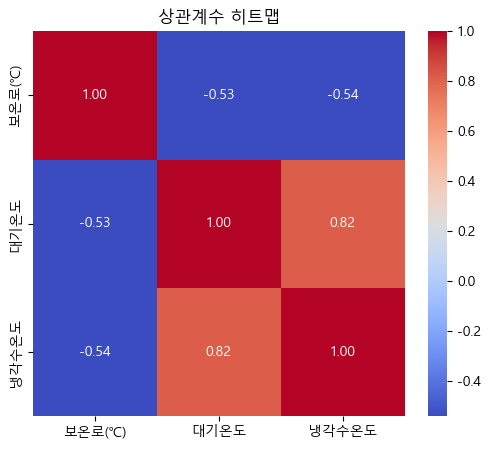

In [23]:
# 상관계수 + Heatmap
cols = ["보온로(℃)", "대기온도", "냉각수온도"]
sub_df = df[cols].dropna()

# 상관계수 계산
corr = sub_df.corr()

# 히트맵 시각화
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관계수 히트맵")
plt.show()

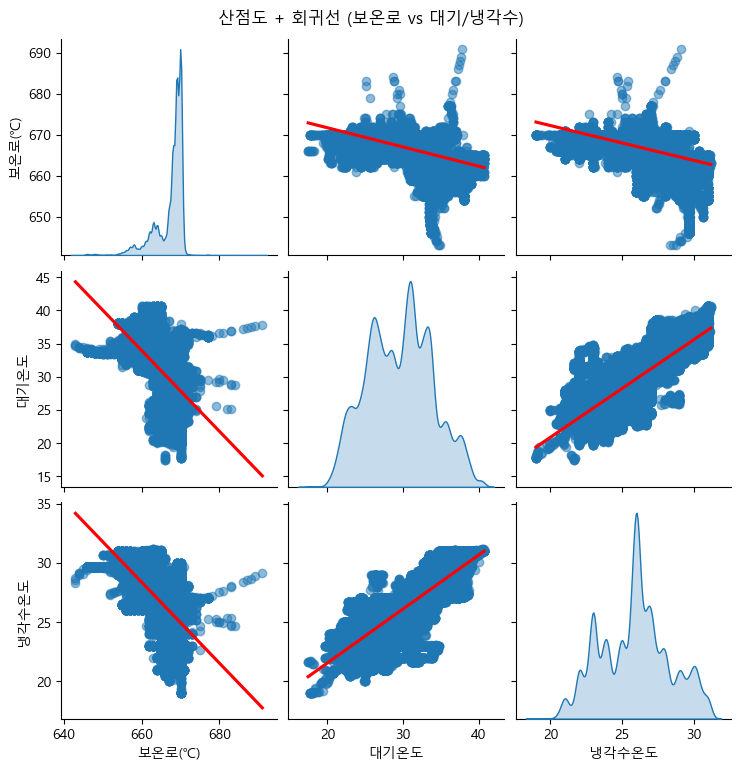

In [24]:
# 산점도 + 회귀선
sns.pairplot(sub_df, kind="reg", diag_kind="kde",
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'alpha':0.5}})
plt.suptitle("산점도 + 회귀선 (보온로 vs 대기/냉각수)", y=1.02)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 보온로(℃)   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                 3.496e+04
Date:                Wed, 24 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:54:50   Log-Likelihood:            -2.2462e+05
No. Observations:               87288   AIC:                         4.492e+05
Df Residuals:                   87286   BIC:                         4.493e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        681.0837      0.075   9086.557      0.0

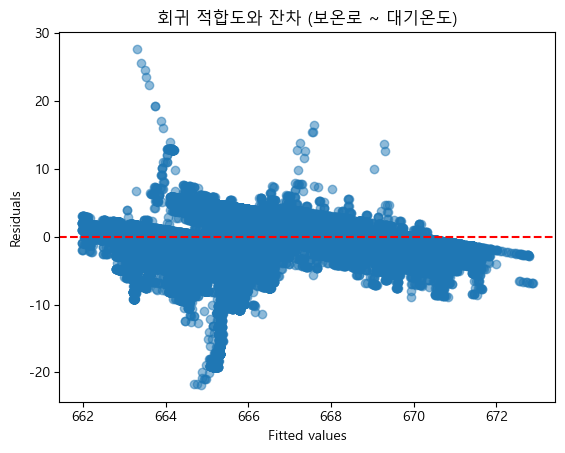

In [25]:
import statsmodels.api as sm
#회귀 적합도와 잔차
X = sub_df["대기온도"]
y = sub_df["보온로(℃)"]

X = sm.add_constant(X)  # 절편 추가
model = sm.OLS(y, X).fit()

print(model.summary())  # 회귀 계수, R² 확인

# 잔차 plot
fitted = model.fittedvalues
residuals = model.resid

plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("회귀 적합도와 잔차 (보온로 ~ 대기온도)")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 보온로(℃)   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 3.581e+04
Date:                Wed, 24 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:54:50   Log-Likelihood:            -2.2432e+05
No. Observations:               87288   AIC:                         4.486e+05
Df Residuals:                   87286   BIC:                         4.487e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        689.2491      0.117   5893.745      0.0

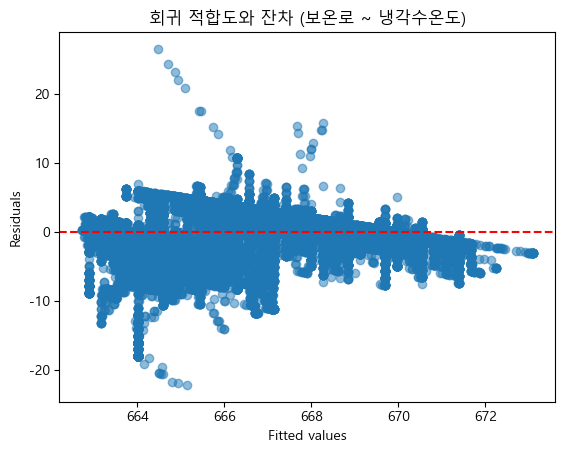

In [26]:
X = sub_df["냉각수온도"]
y = sub_df["보온로(℃)"]

X = sm.add_constant(X)  # 절편 추가
model = sm.OLS(y, X).fit()

print(model.summary())  # 회귀 계수, R² 확인

# 잔차 plot
fitted = model.fittedvalues
residuals = model.resid

plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("회귀 적합도와 잔차 (보온로 ~ 냉각수온도)")
plt.show()

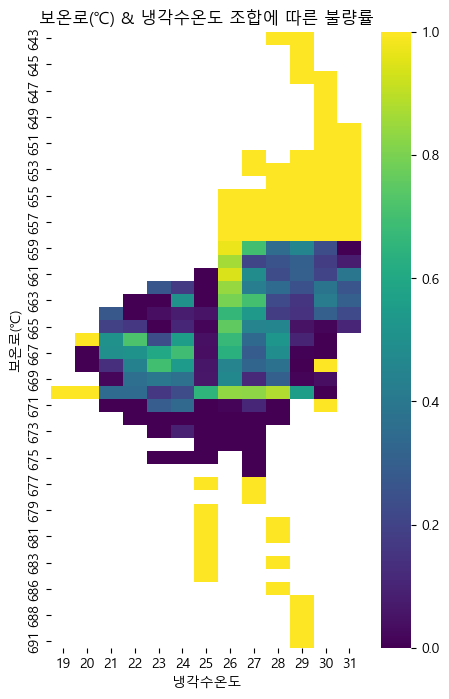

In [27]:
pivot = df.pivot_table(index=df["보온로(℃)"].round().astype(int),
                       columns=df["냉각수온도"].round().astype(int),
                       values="불량여부",
                       aggfunc="mean")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,8))
sns.heatmap(pivot, annot=False, cmap="viridis")
plt.title("보온로(℃) & 냉각수온도 조합에 따른 불량률")
plt.show()

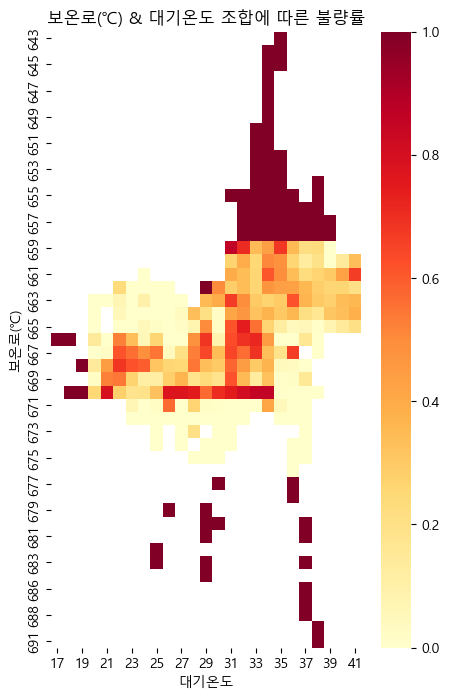

In [28]:
pivot = df.pivot_table(index=df["보온로(℃)"].round().astype(int),
                       columns=df["대기온도"].round().astype(int),
                       values="불량여부",
                       aggfunc="mean")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,8))
sns.heatmap(pivot, annot=False, cmap="YlOrRd")
plt.title("보온로(℃) & 대기온도 조합에 따른 불량률")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_30580\2791507566.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


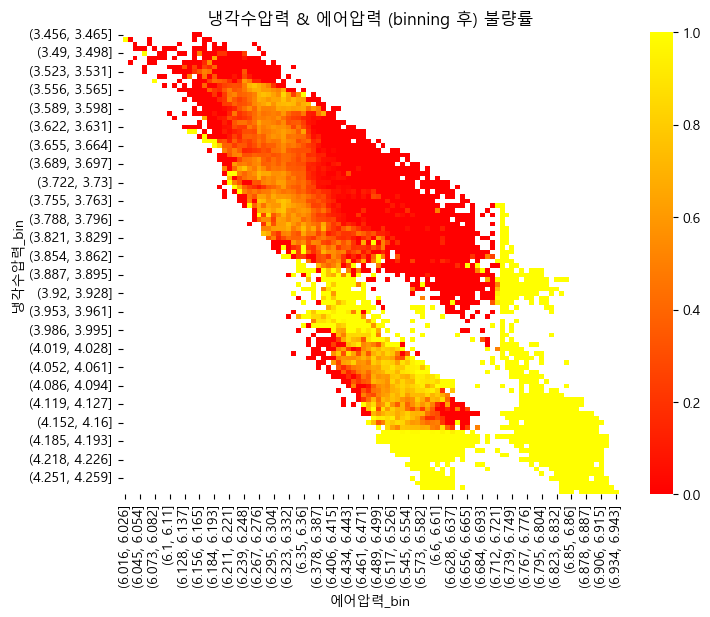

In [29]:
df["냉각수압력_bin"] = pd.cut(df["냉각수압력"], bins=100)
df["에어압력_bin"] = pd.cut(df["에어압력"], bins=100)

pivot = df.pivot_table(
    index="냉각수압력_bin",
    columns="에어압력_bin",
    values="불량여부",
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=False, cmap="autumn")
plt.title("냉각수압력 & 에어압력 (binning 후) 불량률")
plt.show()

In [ ]:
# 모두 주물의 온도에 직접적인 영향을 끼친다는 공통점이 높은 관계수치를 보인 건가...
# 보온로는 660 ~ 675도 사이의 온도만 유지하면 제 역할을 다한 것이라고 주장하고 끝내면 될 듯.
# 그리고 알루미늄 녹는 점이 660.2도이다.
# 히트맵 자료의 설득력이 굉장히 높다.

#### 냉각수 이슈

C:\Users\User\AppData\Local\Temp\ipykernel_30580\4289768749.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


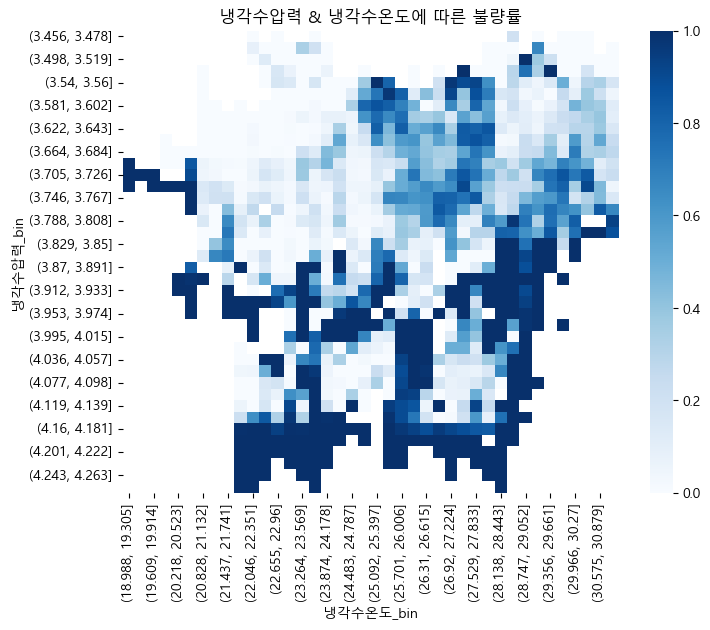

In [ ]:

df["냉각수압력_bin"] = pd.cut(df["냉각수압력"].round(3), bins=40)
df["냉각수온도_bin"] = pd.cut(df["냉각수온도"].round(3), bins=40)

pivot = df.pivot_table(
    index="냉각수압력_bin",
    columns="냉각수온도_bin",
    values="불량여부",
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=False, cmap="Blues")
plt.title("냉각수압력 & 냉각수온도에 따른 불량률")
plt.show()

# 냉각수 특정 압력 수치를 초과하면 불량률이 급증한다.
# 난류 생성 문제를 의미하는 것으로 보인다.

# 일반적으로 레이놀즈 수 4000 이상을 넘기면 적당한 수준의 난류가 생성되어 
# 금형과 주물의 온도를 효과적으로, 균일하게 낮춘다.
# 그러나 냉각수 압력이 적정 값을 초과하면 캐비테이션이 발생해 냉각 효율 저하 및 금형 손상
# 국부 냉각으로 인해 불량품 급증

C:\Users\User\AppData\Local\Temp\ipykernel_39436\3139916241.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


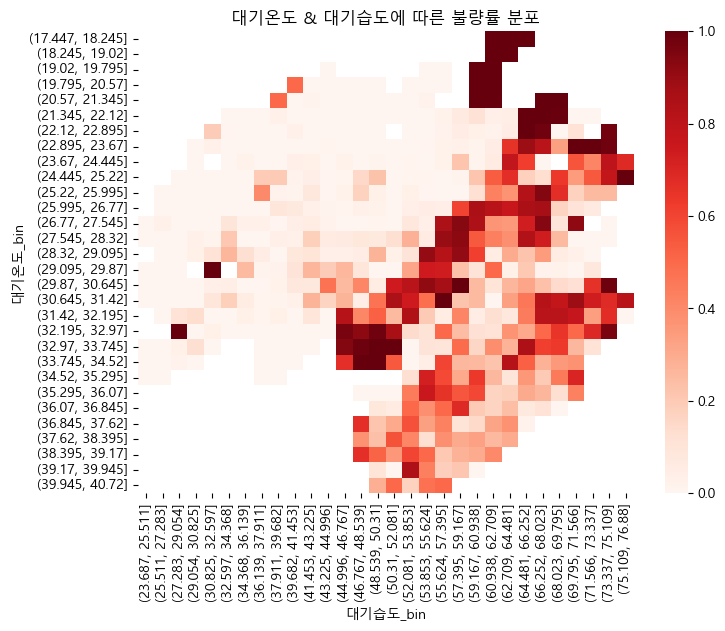

In [53]:

df["대기온도_bin"] = pd.cut(df["대기온도"].round(2), bins=30)
df["대기습도_bin"] = pd.cut(df["대기습도"].round(2), bins=30)

pivot = df.pivot_table(
    index="대기온도_bin",
    columns="대기습도_bin",
    values="불량여부",
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=False, cmap="Reds")
plt.title("대기온도 & 대기습도에 따른 불량률 분포")
plt.show()

# 대기온도 & 대기습도에 따른 불량률 시각화
# 선형적인 패턴을 보인다.
# 온도는 금형 온도 조절에 영향을 주고
# 습도는 그 온도의 전달률에 영향을 주므로
# 설비 외부 온도 조절에도 신경 써야 한다는 가설에 힘이 실린다.

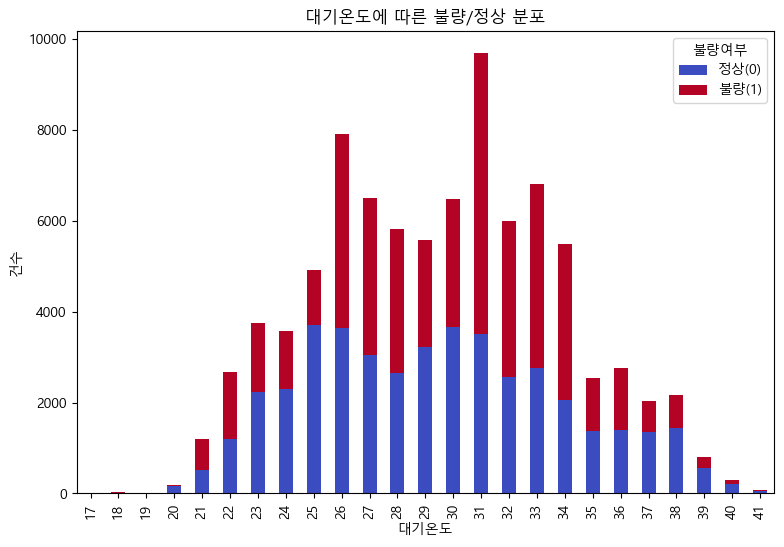

In [52]:
df["대기온도_round"] = df["대기온도"].round().astype(int)

# 불량여부별 개수 집계
stack_data = df.groupby(["대기온도_round", "불량여부"]).size().unstack(fill_value=0)

# 스택형 막대 차트 그리기
stack_data.plot(kind="bar", stacked=True, figsize=(9,6), colormap="coolwarm")

plt.title("대기온도에 따른 불량/정상 분포")
plt.xlabel("대기온도")
plt.ylabel("건수")
plt.legend(title="불량여부", labels=["정상(0)", "불량(1)"])
plt.show()

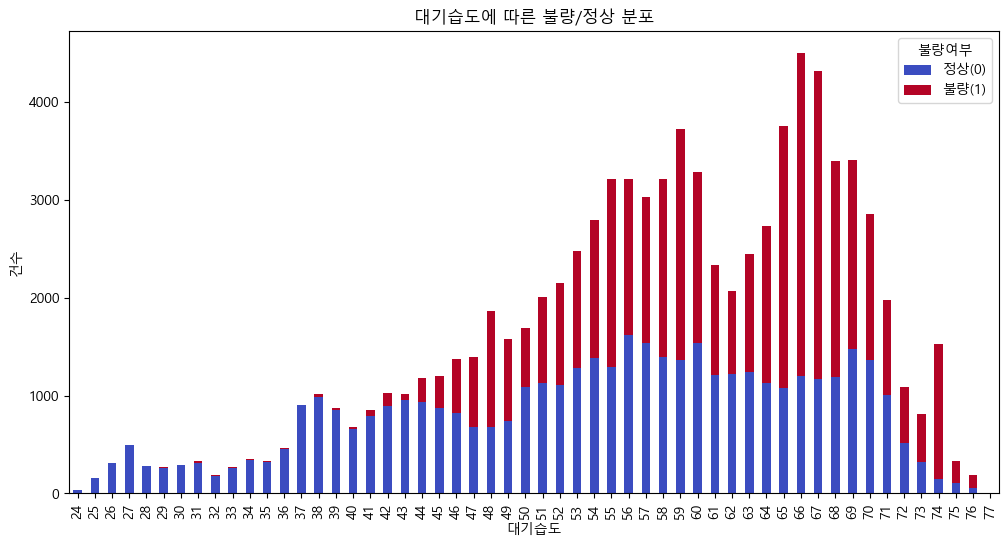

In [ ]:
df["대기습도_round"] = df["대기습도"].round().astype(int)

# 불량여부별 개수 집계
stack_data = df.groupby(["대기습도_round", "불량여부"]).size().unstack(fill_value=0)

# 스택형 막대 차트 그리기
stack_data.plot(kind="bar", stacked=True, figsize=(12,6), colormap="coolwarm")

plt.title("대기습도에 따른 불량/정상 분포")
plt.xlabel("대기습도")
plt.ylabel("건수")
plt.legend(title="불량여부", labels=["정상(0)", "불량(1)"])
plt.show()

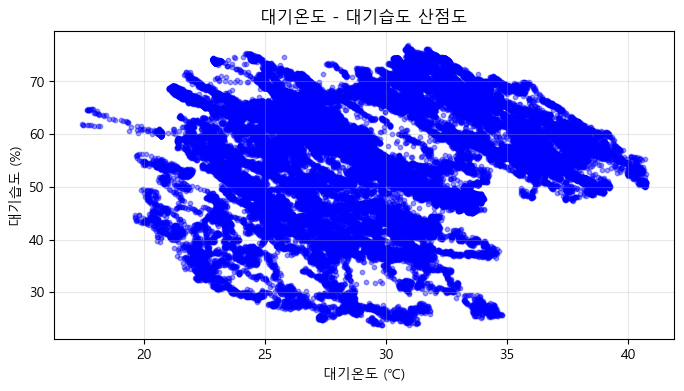

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(df["대기온도"], df["대기습도"], alpha=0.4, s=10, c="blue")

plt.xlabel("대기온도 (℃)")
plt.ylabel("대기습도 (%)")
plt.title("대기온도 - 대기습도 산점도")
plt.grid(True, alpha=0.3)
plt.show()

# 온도-습도가 넓게 퍼져 있다 = 사계절 변화를 그대로 나타내고 있다.